# 07: The Transformer Block

*The fish grows a spine.*

---

We now have all the pieces:
- **Attention:** Gather information from context
- **Position:** Know where tokens are
- **FFN:** Think about what was gathered

But our current architecture has a problem: information flows *through* each layer sequentially. The FFN only sees what attention outputs. The unembed only sees what FFN outputs. Each layer is a bottleneck.

This notebook adds two things that transform our pile of parts into a proper transformer:

**1. Residual connections:** Instead of `x = layer(x)`, we do `x = x + layer(x)`. Information flows *around* layers, not just through them. The original signal is preserved; each layer just adds refinements.

**2. Layer normalization:** Keeps activations stable. Without it, values can drift as they flow through layers—getting too big or too small. LayerNorm recenters things at each step.

Together, these enable *depth*. You can stack transformer blocks and each one helps. Without residuals, stacking makes things worse. With residuals, you can go 12, 24, 96 layers deep.

**The transformer block:**
```
x = x + Attention(LayerNorm(x))
x = x + FFN(LayerNorm(x))
```

That's it. That's the unit of composition that powers GPT, Claude, and every other transformer.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import json
import math

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

Using device: mps


---

## 1. Data and Tokenizer

In [2]:
from transformers import GPT2TokenizerFast

class LilTokenizer:
    """Compact tokenizer for Lil Transformy."""
    
    def __init__(self, gpt2_to_compact, compact_to_gpt2, vocab_size):
        self.gpt2_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
        self.gpt2_to_compact = gpt2_to_compact
        self.compact_to_gpt2 = compact_to_gpt2
        self.vocab_size = vocab_size
        self.pad_id = 0
        self.unk_id = 1
        self.eos_id = 2
    
    def encode(self, text, add_eos=True):
        gpt2_tokens = self.gpt2_tokenizer.encode(text)
        compact_tokens = [self.gpt2_to_compact.get(t, self.unk_id) for t in gpt2_tokens]
        if add_eos:
            compact_tokens.append(self.eos_id)
        return compact_tokens
    
    def decode(self, token_ids):
        gpt2_tokens = []
        for tid in token_ids:
            if tid in [self.pad_id, self.unk_id, self.eos_id]:
                continue
            if tid in self.compact_to_gpt2:
                gpt2_tokens.append(self.compact_to_gpt2[tid])
        return self.gpt2_tokenizer.decode(gpt2_tokens)
    
    def decode_single(self, token_id):
        if token_id == self.pad_id:
            return '<pad>'
        if token_id == self.unk_id:
            return '<unk>'
        if token_id == self.eos_id:
            return '<eos>'
        if token_id in self.compact_to_gpt2:
            return self.gpt2_tokenizer.decode([self.compact_to_gpt2[token_id]])
        return '<???>'
    
    def __len__(self):
        return self.vocab_size
    
    @classmethod
    def load(cls, path):
        with open(path, 'r') as f:
            config = json.load(f)
        gpt2_to_compact = {int(k): v for k, v in config['gpt2_to_compact'].items()}
        compact_to_gpt2 = {int(k): v for k, v in config['compact_to_gpt2'].items()}
        return cls(gpt2_to_compact, compact_to_gpt2, config['vocab_size'])


tokenizer = LilTokenizer.load('tokenizer/tokenizer.json')
print(f"Vocabulary size: {len(tokenizer):,}")

Vocabulary size: 4,096


In [3]:
train_data = np.load('data/train_sequences.npy')
val_data = np.load('data/val_sequences.npy')

print(f"Training sequences: {train_data.shape}")
print(f"Validation sequences: {val_data.shape}")
print(f"Context length: {train_data.shape[1]}")

Training sequences: (1851532, 256)
Validation sequences: (18616, 256)
Context length: 256


---

## 2. Residual Connections: The Idea

A residual connection is almost embarrassingly simple:

```python
# Without residual
x = layer(x)

# With residual
x = x + layer(x)
```

That's it. The output is the input plus whatever the layer computed.

### Why This Matters

**The gradient highway:**

During backpropagation, gradients flow backward through the computation graph. Without residuals, to get gradients to early layers, they have to pass through every subsequent layer's matrix multiplications. Each one can shrink or amplify the gradient.

With residuals, there's a shortcut. The gradient can flow directly back through the addition operation, bypassing all the layer computations. This "gradient highway" keeps training stable even in deep networks.

**Learning deltas:**

Without residuals, each layer has to learn to *preserve* useful information while also *transforming* it. That's hard.

With residuals, the identity is free. The layer only has to learn what to *add*. At initialization, if the layer outputs are near zero, the whole thing is approximately `x = x + 0 = x`. The network starts as identity and learns refinements.

**Enabling depth:**

This is the practical payoff. Without residuals, adding layers eventually hurts performance—the optimization becomes too hard. With residuals, you can stack many layers and each one helps.

ResNet (2015) demonstrated this for image models: they couldn't train 50-layer CNNs until they added residual connections. The same principle applies to transformers.

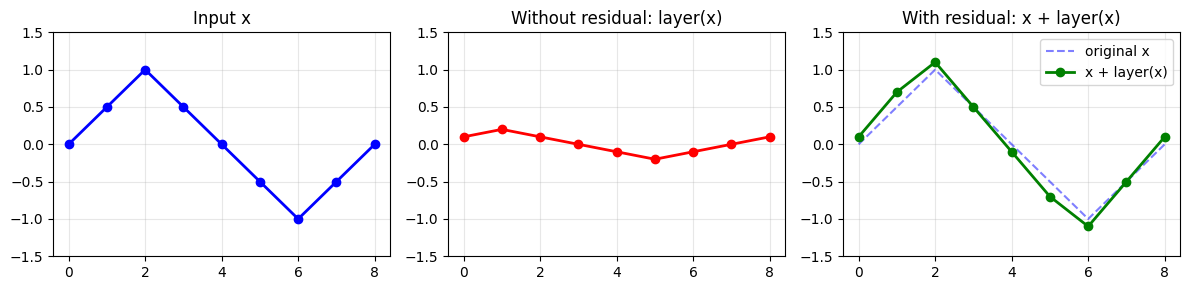

Without residual: the original signal is gone. The layer must preserve it.
With residual: the original signal persists. The layer just adds a delta.


In [4]:
# Let's visualize the residual idea

# Imagine a simple 1D signal
x = torch.tensor([0.0, 0.5, 1.0, 0.5, 0.0, -0.5, -1.0, -0.5, 0.0])

# A "layer" that adds some transformation
layer_output = torch.tensor([0.1, 0.2, 0.1, 0.0, -0.1, -0.2, -0.1, 0.0, 0.1])

# Without residual: the layer output replaces x
without_residual = layer_output

# With residual: the layer output adds to x
with_residual = x + layer_output

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

axes[0].plot(x.numpy(), 'b-o', linewidth=2)
axes[0].set_title('Input x')
axes[0].set_ylim(-1.5, 1.5)
axes[0].grid(True, alpha=0.3)

axes[1].plot(without_residual.numpy(), 'r-o', linewidth=2)
axes[1].set_title('Without residual: layer(x)')
axes[1].set_ylim(-1.5, 1.5)
axes[1].grid(True, alpha=0.3)

axes[2].plot(x.numpy(), 'b--', alpha=0.5, label='original x')
axes[2].plot(with_residual.numpy(), 'g-o', linewidth=2, label='x + layer(x)')
axes[2].set_title('With residual: x + layer(x)')
axes[2].set_ylim(-1.5, 1.5)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Without residual: the original signal is gone. The layer must preserve it.")
print("With residual: the original signal persists. The layer just adds a delta.")

---

## 3. Layer Normalization: The Idea

As values flow through a neural network, they can drift—getting larger and larger, or smaller and smaller. This makes training unstable.

**Layer normalization** fixes this by normalizing activations at each layer:

1. Compute mean and variance across the embedding dimension
2. Normalize to zero mean, unit variance
3. Scale and shift by learned parameters γ and β

```python
def layer_norm(x, gamma, beta):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True)
    x_normalized = (x - mean) / sqrt(var + epsilon)
    return gamma * x_normalized + beta
```

### Why Learnable γ and β?

If we just normalized, we'd force everything to have mean 0 and variance 1. That might not be what the network wants.

The learnable parameters let the network *choose* what scale and shift to use. It starts from a stable baseline (normalized), but can learn to adjust if that helps.

### Pre-norm vs Post-norm

There are two conventions:

**Post-norm** (original transformer):
```python
x = layer_norm(x + attention(x))
x = layer_norm(x + ffn(x))
```

**Pre-norm** (GPT-2 and most modern models):
```python
x = x + attention(layer_norm(x))
x = x + ffn(layer_norm(x))
```

Pre-norm is more stable for training deep networks. We'll use pre-norm.

In [5]:
# Let's see what LayerNorm does

# Create some vectors with different scales
x_small = torch.tensor([[0.1, 0.2, 0.15, 0.05]])
x_large = torch.tensor([[10.0, 20.0, 15.0, 5.0]])
x_offset = torch.tensor([[100.1, 100.2, 100.15, 100.05]])

# Create a LayerNorm (no learnable params for demo, or use PyTorch's)
ln = nn.LayerNorm(4, elementwise_affine=False)  # No gamma/beta for clarity

print("Before LayerNorm:")
print(f"  x_small:  {x_small.numpy()} → mean={x_small.mean():.3f}, std={x_small.std():.3f}")
print(f"  x_large:  {x_large.numpy()} → mean={x_large.mean():.3f}, std={x_large.std():.3f}")
print(f"  x_offset: {x_offset.numpy()} → mean={x_offset.mean():.3f}, std={x_offset.std():.3f}")
print()
print("After LayerNorm:")
print(f"  x_small:  {ln(x_small).detach().numpy().round(3)}")
print(f"  x_large:  {ln(x_large).detach().numpy().round(3)}")
print(f"  x_offset: {ln(x_offset).detach().numpy().round(3)}")
print()
print("All three become identical! LayerNorm removes scale and offset differences.")
print("Only the *relative* pattern matters.")

Before LayerNorm:
  x_small:  [[0.1  0.2  0.15 0.05]] → mean=0.125, std=0.065
  x_large:  [[10. 20. 15.  5.]] → mean=12.500, std=6.455
  x_offset: [[100.1  100.2  100.15 100.05]] → mean=100.125, std=0.065

After LayerNorm:
  x_small:  [[-0.446  1.339  0.446 -1.339]]
  x_large:  [[-0.447  1.342  0.447 -1.342]]
  x_offset: [[-0.447  1.34   0.447 -1.34 ]]

All three become identical! LayerNorm removes scale and offset differences.
Only the *relative* pattern matters.


---

## 4. The Transformer Block

Now we put it together. A transformer block is:

```python
x = x + attention(layer_norm(x))  # Gather context
x = x + ffn(layer_norm(x))        # Think about it
```

This is the fundamental unit. Every transformer—GPT-2, GPT-4, Claude, Llama—is just these blocks stacked.

In [6]:
class CausalSelfAttention(nn.Module):
    """Single-head causal self-attention."""
    
    def __init__(self, d_model, max_seq_len=256):
        super().__init__()
        self.d_model = d_model
        
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)
        
        mask = torch.triu(torch.ones(max_seq_len, max_seq_len), diagonal=1).bool()
        self.register_buffer('mask', mask)
        self.scale = math.sqrt(d_model)
    
    def forward(self, x):
        B, T, C = x.shape
        
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)
        
        scores = (Q @ K.transpose(-2, -1)) / self.scale
        scores = scores.masked_fill(self.mask[:T, :T], float('-inf'))
        attn = F.softmax(scores, dim=-1)
        
        return self.W_o(attn @ V)


class FeedForward(nn.Module):
    """Position-wise feedforward network."""
    
    def __init__(self, d_model, d_ff=None):
        super().__init__()
        if d_ff is None:
            d_ff = 4 * d_model
        
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
    
    def forward(self, x):
        return self.linear2(F.relu(self.linear1(x)))

In [7]:
class TransformerBlock(nn.Module):
    """
    A single transformer block.
    
    This is the fundamental unit of all transformer models:
        x = x + attention(layer_norm(x))
        x = x + ffn(layer_norm(x))
    
    Pre-norm architecture (norm before each sublayer).
    Residual connections around each sublayer.
    """
    
    def __init__(self, d_model, d_ff=None, max_seq_len=256):
        super().__init__()
        
        # Layer norms (one before attention, one before FFN)
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        
        # Attention and FFN
        self.attention = CausalSelfAttention(d_model, max_seq_len)
        self.ffn = FeedForward(d_model, d_ff)
    
    def forward(self, x):
        """
        Args:
            x: [batch, seq_len, d_model]
        Returns:
            [batch, seq_len, d_model]
        """
        # Attention with residual
        x = x + self.attention(self.ln1(x))
        
        # FFN with residual
        x = x + self.ffn(self.ln2(x))
        
        return x

In [8]:
# Test the block
D_MODEL = 128
block = TransformerBlock(D_MODEL)

# Count parameters
block_params = sum(p.numel() for p in block.parameters())
print(f"TransformerBlock parameters: {block_params:,}")
print()
print("Breakdown:")
print(f"  LayerNorm 1: 2 × {D_MODEL} = {2 * D_MODEL}  (gamma and beta)")
print(f"  Attention:   4 × {D_MODEL}² = {4 * D_MODEL * D_MODEL:,}")
print(f"  LayerNorm 2: 2 × {D_MODEL} = {2 * D_MODEL}  (gamma and beta)")
print(f"  FFN:         {D_MODEL}→{4*D_MODEL}→{D_MODEL} = {D_MODEL * 4 * D_MODEL + 4 * D_MODEL + 4 * D_MODEL * D_MODEL + D_MODEL:,}")
print()

# Test forward pass
test_input = torch.randn(2, 10, D_MODEL)
test_output = block(test_input)
print(f"Input shape:  {test_input.shape}")
print(f"Output shape: {test_output.shape}")

TransformerBlock parameters: 197,760

Breakdown:
  LayerNorm 1: 2 × 128 = 256  (gamma and beta)
  Attention:   4 × 128² = 65,536
  LayerNorm 2: 2 × 128 = 256  (gamma and beta)
  FFN:         128→512→128 = 131,712

Input shape:  torch.Size([2, 10, 128])
Output shape: torch.Size([2, 10, 128])


---

## 5. The Complete Model

Now we wrap the transformer block in a complete language model:

```
Tokens → Embed + Position → TransformerBlock → LayerNorm → Unembed → Logits
```

Note the final LayerNorm before unembedding—this is standard in pre-norm architectures.

In [9]:
class TransformerLM(nn.Module):
    """
    Language model with a proper transformer block.
    
    Architecture:
        Tokens → Embed + Position → TransformerBlock → LayerNorm → Unembed
    
    This is the complete transformer architecture (for 1 layer).
    The only thing left to add is more blocks (stacking) and more heads.
    """
    
    def __init__(self, vocab_size, d_model, d_ff=None, max_seq_len=256):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        
        if d_ff is None:
            d_ff = 4 * d_model
        self.d_ff = d_ff
        
        # Embeddings
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_seq_len, d_model)
        
        # The transformer block
        self.block = TransformerBlock(d_model, d_ff, max_seq_len)
        
        # Final layer norm (standard in pre-norm architectures)
        self.ln_final = nn.LayerNorm(d_model)
        
        # Output
        self.unembed = nn.Linear(d_model, vocab_size)
    
    def forward(self, x):
        """
        Args:
            x: Token IDs, shape [batch, seq_len]
        Returns:
            Logits, shape [batch, seq_len, vocab_size]
        """
        B, T = x.shape
        
        # Embed tokens and positions
        tok_emb = self.token_embedding(x)
        pos_emb = self.position_embedding(torch.arange(T, device=x.device))
        x = tok_emb + pos_emb
        
        # Transformer block
        x = self.block(x)
        
        # Final norm and output
        x = self.ln_final(x)
        logits = self.unembed(x)
        
        return logits
    
    def generate(self, prompt_tokens, max_new_tokens=50, temperature=1.0):
        """Generate tokens autoregressively."""
        self.eval()
        tokens = list(prompt_tokens)
        generated = []
        
        with torch.no_grad():
            for _ in range(max_new_tokens):
                context = tokens[-self.max_seq_len:]
                x = torch.tensor([context], device=next(self.parameters()).device)
                
                logits = self.forward(x)
                next_logits = logits[0, -1]
                
                probs = F.softmax(next_logits / temperature, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1).item()
                
                generated.append(next_token)
                tokens.append(next_token)
                
                if next_token == 2:  # EOS
                    break
        
        return generated

In [11]:
# === Model Parameters ===
VOCAB_SIZE = len(tokenizer)  # 4096
D_MODEL = 128
D_FF = 4 * D_MODEL  # 512
MAX_SEQ_LEN = 256

# Create model
model = TransformerLM(VOCAB_SIZE, D_MODEL, D_FF, MAX_SEQ_LEN).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())

print(f"Total parameters: {num_params:,}")
print()
print("Breakdown:")
print(f"  Token embedding:    {VOCAB_SIZE * D_MODEL:,}")
print(f"  Position embedding: {MAX_SEQ_LEN * D_MODEL:,}")
print(f"  Transformer block:  {sum(p.numel() for p in model.block.parameters()):,}")
print(f"  Final LayerNorm:    {2 * D_MODEL}  ← NEW")
print(f"  Unembed:            {D_MODEL * VOCAB_SIZE + VOCAB_SIZE:,}")
print()
print(f"Notebook 06 had 1,282,048 params.")
print(f"We added {2 * D_MODEL + 2 * D_MODEL + 2 * D_MODEL} params for 3 LayerNorms.")

Total parameters: 1,283,456

Breakdown:
  Token embedding:    524,288
  Position embedding: 32,768
  Transformer block:  197,760
  Final LayerNorm:    256  ← NEW
  Unembed:            528,384

Notebook 06 had 1,282,048 params.
We added 768 params for 3 LayerNorms.


---

## 6. Training

In [12]:
# === Training Parameters ===
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
NUM_EPOCHS = 1
EVAL_EVERY = 500

def make_batch(data, batch_indices):
    """Create a training batch."""
    sequences = data[batch_indices]
    x = torch.tensor(sequences[:, :-1], dtype=torch.long, device=device)
    y = torch.tensor(sequences[:, 1:], dtype=torch.long, device=device)
    return x, y

def evaluate(model, data, num_batches=50):
    """Evaluate model on validation data."""
    model.eval()
    total_loss = 0
    total_tokens = 0
    
    indices = np.random.choice(len(data), size=num_batches * BATCH_SIZE, replace=False)
    
    with torch.no_grad():
        for i in range(num_batches):
            batch_idx = indices[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
            x, y = make_batch(data, batch_idx)
            
            logits = model(x)
            logits_flat = logits.view(-1, VOCAB_SIZE)
            y_flat = y.view(-1)
            
            loss = F.cross_entropy(logits_flat, y_flat)
            
            total_loss += loss.item() * y_flat.numel()
            total_tokens += y_flat.numel()
    
    model.train()
    avg_loss = total_loss / total_tokens
    return {'loss': avg_loss, 'perplexity': math.exp(avg_loss)}


# Setup
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
steps_per_epoch = len(train_data) // BATCH_SIZE
total_steps = steps_per_epoch * NUM_EPOCHS

print(f"Steps per epoch: {steps_per_epoch:,}")
print(f"Total steps: {total_steps:,}")

Steps per epoch: 28,930
Total steps: 28,930


In [13]:
# Training loop
history = {'train_loss': [], 'val_loss': [], 'val_perplexity': []}

print("Starting training...")
print("=" * 60)

step = 0
running_loss = 0

for epoch in range(NUM_EPOCHS):
    perm = np.random.permutation(len(train_data))
    epoch_pbar = tqdm(range(steps_per_epoch), desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    
    for batch_num in epoch_pbar:
        batch_idx = perm[batch_num * BATCH_SIZE:(batch_num + 1) * BATCH_SIZE]
        x, y = make_batch(train_data, batch_idx)
        
        optimizer.zero_grad()
        logits = model(x)
        
        logits_flat = logits.view(-1, VOCAB_SIZE)
        y_flat = y.view(-1)
        loss = F.cross_entropy(logits_flat, y_flat)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        step += 1
        
        if step % EVAL_EVERY == 0:
            avg_train_loss = running_loss / EVAL_EVERY
            val_metrics = evaluate(model, val_data)
            
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(val_metrics['loss'])
            history['val_perplexity'].append(val_metrics['perplexity'])
            
            epoch_pbar.set_postfix({
                'loss': f"{avg_train_loss:.3f}",
                'val_loss': f"{val_metrics['loss']:.3f}",
                'ppl': f"{val_metrics['perplexity']:.1f}"
            })
            
            running_loss = 0

print("\nTraining complete!")

Starting training...


Epoch 1/1:   0%|          | 0/28930 [00:00<?, ?it/s]


Training complete!


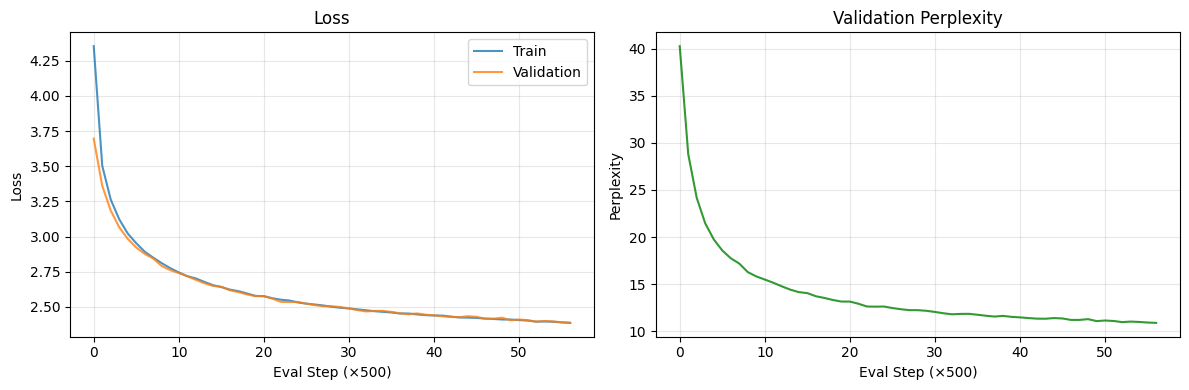


Final validation loss: 2.387
Final validation perplexity: 10.9


In [14]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_loss'], label='Train', alpha=0.8)
axes[0].plot(history['val_loss'], label='Validation', alpha=0.8)
axes[0].set_xlabel(f'Eval Step (×{EVAL_EVERY})')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['val_perplexity'], color='green', alpha=0.8)
axes[1].set_xlabel(f'Eval Step (×{EVAL_EVERY})')
axes[1].set_ylabel('Perplexity')
axes[1].set_title('Validation Perplexity')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('07_training_curves.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nFinal validation loss: {history['val_loss'][-1]:.3f}")
print(f"Final validation perplexity: {history['val_perplexity'][-1]:.1f}")

---

## 7. Comparison

In [15]:
# Load previous results
checkpoint_03 = torch.load('03_bigram.pt', map_location='cpu', weights_only=False)
checkpoint_04 = torch.load('04_attention.pt', map_location='cpu', weights_only=False)
checkpoint_05 = torch.load('05_positional.pt', map_location='cpu', weights_only=False)
checkpoint_06 = torch.load('06_ffn.pt', map_location='cpu', weights_only=False)

print("=" * 70)
print("COMPARISON")
print("=" * 70)
print()
print(f"{'Model':<35} {'Params':<12} {'Epochs':<8} {'Val PPL':<10}")
print("-" * 70)
print(f"{'03: Bigram':<35} {'1,052,672':<12} {'1':<8} {checkpoint_03['history']['val_perplexity'][-1]:<10.1f}")
print(f"{'04: + Attention':<35} {'1,118,208':<12} {'3':<8} {checkpoint_04['history']['val_perplexity'][-1]:<10.1f}")
print(f"{'05: + Position':<35} {'1,151,104':<12} {'1':<8} {checkpoint_05['history']['val_perplexity'][-1]:<10.1f}")
print(f"{'06: + FFN':<35} {'1,282,048':<12} {'1':<8} {checkpoint_06['history']['val_perplexity'][-1]:<10.1f}")
print(f"{'07: + Residual & LayerNorm (this)':<35} {f'{num_params:,}':<12} {'1':<8} {history['val_perplexity'][-1]:<10.1f}")
print()
print("Residuals and LayerNorm are more about stability than raw performance.")
print("The real payoff comes when we stack multiple blocks.")

COMPARISON

Model                               Params       Epochs   Val PPL   
----------------------------------------------------------------------
03: Bigram                          1,052,672    1        35.8      
04: + Attention                     1,118,208    3        25.0      
05: + Position                      1,151,104    1        17.7      
06: + FFN                           1,282,048    1        13.4      
07: + Residual & LayerNorm (this)   1,283,456    1        10.9      

Residuals and LayerNorm are more about stability than raw performance.
The real payoff comes when we stack multiple blocks.


---

## 8. Generation

In [16]:
def generate_and_print(prompt, max_tokens=50, temperature=1.0):
    """Generate from a prompt and print results."""
    prompt_tokens = tokenizer.encode(prompt, add_eos=False)
    generated_tokens = model.generate(prompt_tokens, max_new_tokens=max_tokens, temperature=temperature)
    generated_text = tokenizer.decode(generated_tokens)
    
    print(f"Prompt: {prompt}")
    print(f"Generated: {generated_text}")
    print()


print("=" * 60)
print("GENERATION TEST")
print("=" * 60)
print()

test_prompts = [
    "Once upon a time",
    "The little girl",
    "Once upon a time there was a little girl named Lily. She",
    "The boy was sad because his toy was broken. His mom said",
]

for prompt in test_prompts:
    generate_and_print(prompt, max_tokens=40)

GENERATION TEST

Prompt: Once upon a time
Generated:  there were two young friends - a green hill all by itself. They were so happy that they made a pirate huge race and lots of! They both wanted to the huge tent, they wanted

Prompt: The little girl
Generated:  said, "We are gathering them!" The second scooped the into the sandy reef and took out a bucket, which was a and it looked.

"It was cold

Prompt: Once upon a time there was a little girl named Lily. She
Generated:  loved to eat cookies and ate them together. One day, Lily's mom took her to a candy and she went outside to eat. Lily's mom told her and how much they loved her mom and

Prompt: The boy was sad because his toy was broken. His mom said
Generated:  it was important for the puppy again. The end.



---

## 9. Visualizing the Residual Stream

One nice thing about residual connections: we can peek at the representation at different stages.

In [17]:
def analyze_residual_stream(text):
    """
    Show how the representation changes at each stage.
    """
    tokens = tokenizer.encode(text, add_eos=False)
    x = torch.tensor([tokens], device=device)
    
    model.eval()
    with torch.no_grad():
        B, T = x.shape
        
        # Stage 1: After embedding
        tok_emb = model.token_embedding(x)
        pos_emb = model.position_embedding(torch.arange(T, device=device))
        after_embed = tok_emb + pos_emb
        
        # Stage 2: After attention (with residual)
        attn_input = model.block.ln1(after_embed)
        attn_output = model.block.attention(attn_input)
        after_attn = after_embed + attn_output  # Residual!
        
        # Stage 3: After FFN (with residual)
        ffn_input = model.block.ln2(after_attn)
        ffn_output = model.block.ffn(ffn_input)
        after_ffn = after_attn + ffn_output  # Residual!
        
        # Stage 4: After final norm
        final = model.ln_final(after_ffn)
    
    # Compute norms at each stage (measure of "how much stuff")
    stages = [
        ('After embed', after_embed),
        ('After attention', after_attn),
        ('After FFN', after_ffn),
        ('After final norm', final),
    ]
    
    print(f"Text: {text}")
    print(f"Tokens: {len(tokens)}")
    print()
    print("Representation norm at each stage (averaged over positions):")
    print("-" * 50)
    
    for name, tensor in stages:
        # Norm per position, then average
        norms = tensor[0].norm(dim=-1)  # [seq_len]
        print(f"  {name:<20}: mean={norms.mean():.2f}, std={norms.std():.2f}")
    
    print()
    print("The residual connections keep the scale relatively stable.")
    print("LayerNorm at the end normalizes for the final projection.")


analyze_residual_stream("Once upon a time there was a little girl")

Text: Once upon a time there was a little girl
Tokens: 9

Representation norm at each stage (averaged over positions):
--------------------------------------------------
  After embed         : mean=14.09, std=5.10
  After attention     : mean=27.08, std=5.08
  After FFN           : mean=47.21, std=6.28
  After final norm    : mean=16.39, std=0.85

The residual connections keep the scale relatively stable.
LayerNorm at the end normalizes for the final projection.


---

## Summary

### What We Added

**Residual connections:**
```python
x = x + layer(x)
```
Information flows around layers, not just through them. Each layer adds refinements to the existing representation.

**Layer normalization:**
```python
x_norm = (x - mean) / std
x_out = gamma * x_norm + beta
```
Keeps activations stable across layers. Learnable γ and β let the model adjust the scale.

### The Transformer Block

```python
x = x + attention(layer_norm(x))
x = x + ffn(layer_norm(x))
```

This is the fundamental unit. Everything else is just stacking these blocks.

### Why This Matters

1. **Gradient flow:** Residuals provide a "highway" for gradients to flow back to early layers
2. **Stable training:** LayerNorm prevents activations from exploding or vanishing
3. **Enables depth:** Without these, stacking layers makes things worse. With them, you can stack many layers and each helps.

### What's Next

- **Stacking:** Multiple transformer blocks (notebook 08)
- **Multi-head attention:** Parallel attention patterns (notebook 09)

We now have a proper transformer. It's just a small one.

In [18]:
# Save model checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'vocab_size': VOCAB_SIZE,
    'd_model': D_MODEL,
    'd_ff': D_FF,
    'max_seq_len': MAX_SEQ_LEN,
    'n_layers': 1,
    'history': history,
}

torch.save(checkpoint, '07_transformer_block.pt')
print("Model saved to 07_transformer_block.pt")

Model saved to 07_transformer_block.pt


In [19]:
print("=" * 60)
print("NOTEBOOK 07 COMPLETE")
print("=" * 60)
print(f"\nArchitecture: Embed + Position → TransformerBlock → Unembed")
print(f"Parameters: {num_params:,}")
print(f"Training: {NUM_EPOCHS} epoch")
print(f"Final perplexity: {history['val_perplexity'][-1]:.1f}")
print()
print("The fish has a spine.")
print("Next: Stack multiple blocks. The fish grows longer.")

NOTEBOOK 07 COMPLETE

Architecture: Embed + Position → TransformerBlock → Unembed
Parameters: 1,283,456
Training: 1 epoch
Final perplexity: 10.9

The fish has a spine.
Next: Stack multiple blocks. The fish grows longer.
